# NLP Disaster Tweets Kaggle Mini-Project

When natural disasters strike, time is of the essence. The more warning time we have, the better our response will be. In today’s age, where a majority of people have access to the internet or a smart phone, social media sites are great places to find current events happening right now. In this notebook we will explore a data set of Tweets and classify them as being real reports of a disaster or not. We will use Natural Language Processing techniques to reshape, analyze, and classify disaster tweets.

The Github Repo for this notebook can be found [here](https://github.com/poreeves/NLP-Disaster-Tweets).

We will be using the Tensorflow and Keras Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import io

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, SimpleRNN, Dense, LSTM, BatchNormalization,GlobalMaxPool1D, Dropout
from keras.models import Sequential
from keras.preprocessing import sequence


I created this notebook in Google Colabs. And easy way to import the data into this notebook is to download the data sets [here](https://www.kaggle.com/competitions/nlp-getting-started/data) and then browser them using the cell below.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


# EDA

Now that we have the data imported let's take a look at it.

In [3]:
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
df_sample_sub = pd.read_csv(io.BytesIO(uploaded['sample_submission.csv']))


There were three csv files. The train csv file contains tweets with their classifiers, disaster or not. The test csv file just contains the tweets. The sample submission file will be used to upload our results to Kaggle.

In [4]:
print(df_train.info())
print(df_test.info())
print(df_sample_sub.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0  

Our training dataset has 7613 tweets with information about the tweet and its classifier. The testing dataset has 3263 tweets with information about the tweet but no classifier.

Let’s create a clean data frame that only has what we need for our model.

In [19]:
df_train_clean = df_train[['id','text','target']]
df_test_clean = df_test[['id','text']]

In [16]:
df_train_clean.head()


,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
df_test_clean.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


Now that we have removed any unnecessary features, let's take a look at the distribution of disaster tweets and not disaster tweets.

In [7]:
df_train_clean['target'].value_counts()


0    4342
1    3271
Name: target, dtype: int64

In our training set we have 4342 not disaster tweets and 3271 disasters tweets. To get a picture of this break down, let's create a graph.

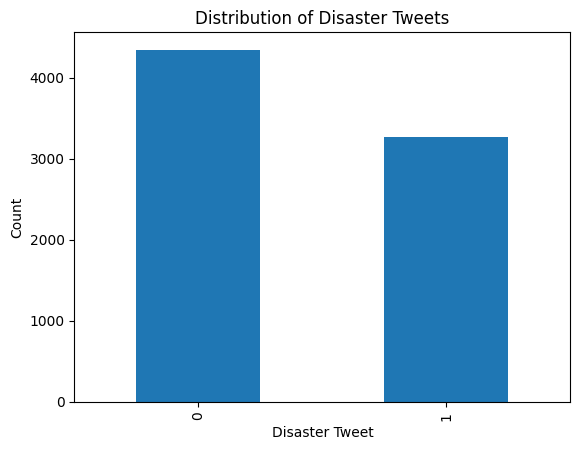

In [8]:
df_train_clean['target'].value_counts().plot(kind='bar', title='Distribution of Disaster Tweets Labels')
plt.xlabel('Disaster Tweet')
plt.ylabel('Count')
plt.show()

As we can see we have more non-disaster tweets than disaster tweets but not so much so that it will cause a problem for the models to come.

Let's take a look at the text of each tweets. First let's see what the disaster  tweets look like.

In [29]:
df_train_clean[df_train_clean['target'] == 1]['text']


0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3271, dtype: object

Now the non-disaster tweets.

In [30]:
df_train_clean[df_train_clean['target'] == 0]['text']

15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
                              ...                        
7581    @engineshed Great atmosphere at the British Li...
7582    Cramer: Iger's 3 words that wrecked Disney's s...
7584    These boxes are ready to explode! Exploding Ki...
7587                                   Sirens everywhere!
7593    I just heard a really loud bang and everyone i...
Name: text, Length: 4342, dtype: object

Now let’s prepare our data for our model. First, we will create a training set with the tweets and classifiers. Then create a set of our test tweets that we will use to test our model.

In [31]:
X_train = df_train_clean['text'].values
y_train = df_train_clean['target'].values
X_test = df_test_clean['text'].values
print(len(X_train))
print(len(y_train))
print(len(X_test))

7613
7613
3263


# RNN Model

The first thing we need to do is reshape our tweets into a format that our model can understand. We will do this by creating a dictionary of all the words in all the tweets. Then we tokenize the words, making them numbers. Next we will find the length of the longest tweet and pad the rest of the tweets so they are all the same length.

So, let's merge our train and test dataset. This way we will get all the words that appear in both sets into our dictionary.

In [32]:
all_text = np.concatenate((X_train, X_test))
print(len(all_text))

10876


Next, we will create our dictionary using the Tokenizer model.

In [33]:
token = Tokenizer()
token.fit_on_texts(all_text)
vocab = len(token.word_index) + 1
print(vocab)

29320


It looks like we have 29320 unique words. Next let's find the longest tweet.

In [34]:
max_len = 0
for text in all_text:
    if len(text) > max_len:
        max_len = len(text)
print(max_len)

157


Now that we know our longest tweet is 157 words long, we can translate our tweets to lists of numbers.

In [35]:
X_train_token = token.texts_to_sequences(X_train)
X_test_token = token.texts_to_sequences(X_test)

Let's take a look at our newly translated tweets.

In [36]:
print(X_train_token[0])
print(X_test_token[0])

[114, 5944, 24, 4, 850, 8, 21, 253, 151, 1820, 3841, 88, 41]
[32, 794, 5, 1522, 131, 97]


In [37]:
X_train_pad = sequence.pad_sequences(X_train_token, maxlen=max_len, padding='post')
X_test_pad = sequence.pad_sequences(X_test_token, maxlen=max_len, padding='post')

Our final step is to pad the lists of tweets, so they are all the same length. Now that we have a list of all the tweets that have been tokenized and are the same length it is time for our model.

For our first model, let’s just use the simple Recurrent Neural Network. A RNN takes sequence data, like our tweets, and uses feedback within the network to update the model as it processes the sequence of data. The model will create predictions with the model, check the error rate, and then update the bias and weights to adjust the model. Let's get started.

In [38]:
model = Sequential()

model.add(Embedding(input_dim=vocab, output_dim= 128, input_length=max_len))

model.add(SimpleRNN(128))

model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 157, 128)          3752960   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 3785985 (14.44 MB)
Trainable params: 3785985 (14.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


So now that our simple RNN model is built, we used the Adam optimizer with learning rate 0.001 and a sigmoid activation function in our output layer to create a binary, disaster or not, output.

Let's test the model on our training data, reserving 20% of the data for validation.

In [39]:
model_hist = model.fit(X_train_pad, y_train, epochs=10, batch_size=128,validation_split=0.2)

Epoch 1/10
48/48 [==============================] - 22s 331ms/step - loss: 0.6864 - accuracy: 0.5732 - val_loss: 0.6967 - val_accuracy: 0.5345
Epoch 2/10
48/48 [==============================] - 14s 292ms/step - loss: 0.6877 - accuracy: 0.5637 - val_loss: 0.7047 - val_accuracy: 0.5345
Epoch 3/10
48/48 [==============================] - 11s 237ms/step - loss: 0.6841 - accuracy: 0.5709 - val_loss: 0.7055 - val_accuracy: 0.5246
Epoch 4/10
48/48 [==============================] - 10s 201ms/step - loss: 0.6865 - accuracy: 0.5660 - val_loss: 0.6933 - val_accuracy: 0.5345
Epoch 5/10
48/48 [==============================] - 12s 243ms/step - loss: 0.6804 - accuracy: 0.5824 - val_loss: 0.6978 - val_accuracy: 0.5345
Epoch 6/10
48/48 [==============================] - 10s 209ms/step - loss: 0.6937 - accuracy: 0.5514 - val_loss: 0.7128 - val_accuracy: 0.5522
Epoch 7/10
48/48 [==============================] - 10s 208ms/step - loss: 0.6797 - accuracy: 0.5949 - val_loss: 0.6908 - val_accuracy: 0.5456

Now that our model is fit, let's take a look at the metrics, accuracy and loss.

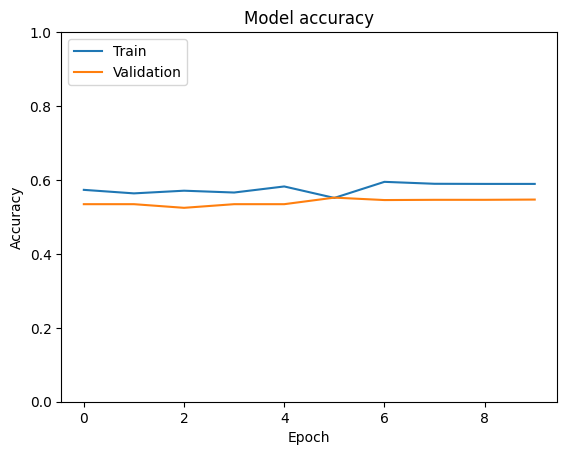

In [40]:
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.ylim(0, 1)
plt.show()

It appears that our simple RNN model wasn't able to improve its accuracy much over the ten epochs. We will discuss why soon.

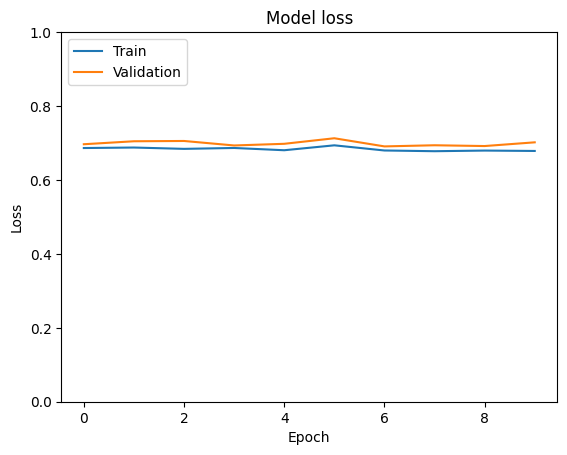

In [41]:
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.ylim(0, 1)
plt.show()

As with our accuracy graph, it didn't seem like the model was learning too much during each epoch.

One issue with simple RNN models is the vanishing gradient problem. Our model can’t back propagate far enough in each sequence to memorize the order of words and thus make an accurate prediction and update itself. Let's try a more complex type of RNN model.

# LSTM RNN Model

The Long Short Term Memory (LSTM) RNN model addresses the issue of the vanishing gradient. It is specially designed to allow for the memorization in long sequence data so that the model is able create accurate predictions. Let's try it out.

In [42]:
model2 = Sequential()

model2.add(Embedding(input_dim=vocab, output_dim= 128, input_length=max_len))

model2.add(LSTM(128,return_sequences = True))
model2.add(GlobalMaxPool1D())
model2.add(BatchNormalization())
model2.add(Dropout(0.50))

model2.add(Dense(256, activation='relu'))

model2.add(Dropout(0.25))

model2.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 157, 128)          3752960   
                                                                 
 lstm (LSTM)                 (None, 157, 128)          131584    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)              

In [43]:
model2_hist = model2.fit(X_train_pad, y_train, epochs=10, batch_size=128,validation_split=0.3)

Epoch 1/10
42/42 [==============================] - 12s 182ms/step - loss: 0.5771 - accuracy: 0.6962 - val_loss: 0.6713 - val_accuracy: 0.6563
Epoch 2/10
42/42 [==============================] - 5s 131ms/step - loss: 0.3130 - accuracy: 0.8803 - val_loss: 0.6540 - val_accuracy: 0.7859
Epoch 3/10
42/42 [==============================] - 5s 116ms/step - loss: 0.1474 - accuracy: 0.9480 - val_loss: 0.6200 - val_accuracy: 0.7574
Epoch 4/10
42/42 [==============================] - 4s 85ms/step - loss: 0.0801 - accuracy: 0.9737 - val_loss: 0.5964 - val_accuracy: 0.6782
Epoch 5/10
42/42 [==============================] - 3s 68ms/step - loss: 0.0472 - accuracy: 0.9861 - val_loss: 0.5945 - val_accuracy: 0.7071
Epoch 6/10
42/42 [==============================] - 2s 57ms/step - loss: 0.0319 - accuracy: 0.9910 - val_loss: 0.5403 - val_accuracy: 0.7513
Epoch 7/10
42/42 [==============================] - 3s 61ms/step - loss: 0.0289 - accuracy: 0.9921 - val_loss: 0.5494 - val_accuracy: 0.7487
Epoch 8/1

So now that our model is built and fitted, let's take a look at the metrics.

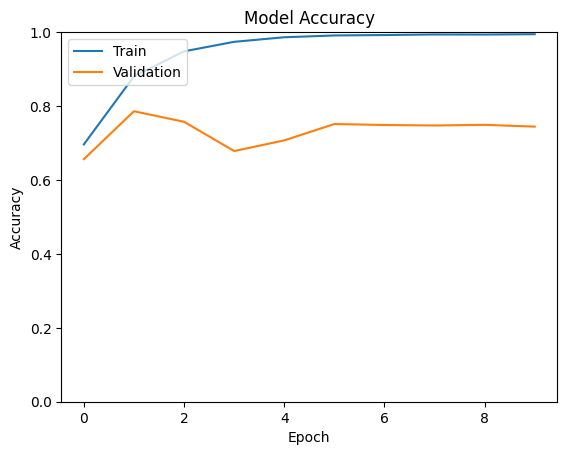

In [101]:
plt.plot(model2_hist.history['accuracy'])
plt.plot(model2_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.ylim(0, 1)
plt.show()

As we can see, accuracy increased over the epochs. Our model was able to better fit the data. However, our validation accuracy seems to have risen, dropped, then flattened out. This could be signs that our model is overfitting the training data.

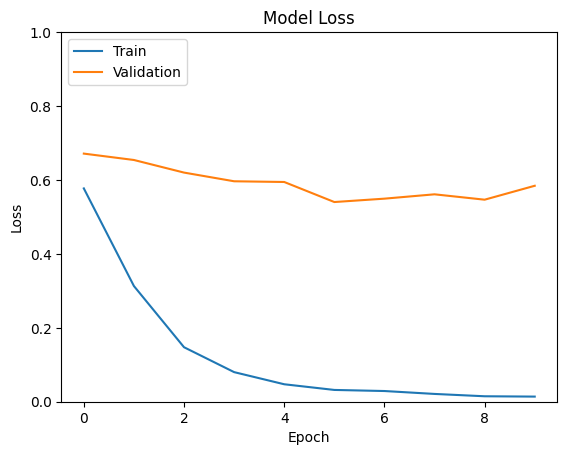

In [100]:
plt.plot(model2_hist.history['loss'])
plt.plot(model2_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.ylim(0, 1)
plt.show()

As with our accuracy graph our model is now learning after each epoch. However, our validation loss seems to slightly decrease but doesn't really go down. That is another sign that our model might have trained too well for the training.

Let's use our model to predict our test data.

In [90]:
pred = model2.predict(X_test_pad)

102/102 [==============================] - 1s 5ms/step


Now that we have our predictions for the test dataset let's create a csv so we can upload it to Kaggle and see how well the model did.

In [91]:
df_sample_sub.shape

(3263, 2)

In [92]:
print(len(pred))

3263


In [93]:
for i in range(len(pred)):
    if pred[i] > 0.5:
        df_sample_sub['target'][i] = 1
    else:
        df_sample_sub['target'][i] = 0

Our predictions were 76% accurate! To try and improve on that score, let's see if we can address that overfitting issue.

# Tuning our LSTM Model

To help prevent overfitting let's add another dropout layer and reduce the number of hidden units.

In [99]:
model3 = Sequential()

model3.add(Embedding(input_dim=vocab, output_dim= 64, input_length=max_len))

model3.add(LSTM(64,return_sequences = True))
model3.add(GlobalMaxPool1D())
model3.add(BatchNormalization())
model3.add(Dropout(0.50))

model3.add(Dense(256, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(128, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 157, 64)           1876480   
                                                                 
 lstm_29 (LSTM)              (None, 157, 64)           33024     
                                                                 
 global_max_pooling1d_23 (G  (None, 64)                0         
 lobalMaxPooling1D)                                              
                                                                 
 batch_normalization_45 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout_58 (Dropout)        (None, 64)                0         
                                                                 
 dense_55 (Dense)            (None, 256)             

In [87]:
model3_hist = model3.fit(X_train_pad, y_train, epochs=10, batch_size=128,validation_split=0.3)

Epoch 1/10
42/42 [==============================] - 14s 229ms/step - loss: 0.7964 - accuracy: 0.5759 - val_loss: 0.6860 - val_accuracy: 0.5582
Epoch 2/10
42/42 [==============================] - 5s 122ms/step - loss: 0.6490 - accuracy: 0.6656 - val_loss: 0.6897 - val_accuracy: 0.5582
Epoch 3/10
42/42 [==============================] - 6s 153ms/step - loss: 0.5063 - accuracy: 0.7681 - val_loss: 0.6949 - val_accuracy: 0.5582
Epoch 4/10
42/42 [==============================] - 4s 100ms/step - loss: 0.3924 - accuracy: 0.8274 - val_loss: 0.6865 - val_accuracy: 0.5582
Epoch 5/10
42/42 [==============================] - 4s 92ms/step - loss: 0.2826 - accuracy: 0.8861 - val_loss: 0.6731 - val_accuracy: 0.5582
Epoch 6/10
42/42 [==============================] - 4s 90ms/step - loss: 0.1973 - accuracy: 0.9270 - val_loss: 0.6521 - val_accuracy: 0.5644
Epoch 7/10
42/42 [==============================] - 2s 44ms/step - loss: 0.1312 - accuracy: 0.9544 - val_loss: 0.6189 - val_accuracy: 0.6436
Epoch 8/

Let's take a look and see if our model's validation accuracy and loss have improved.

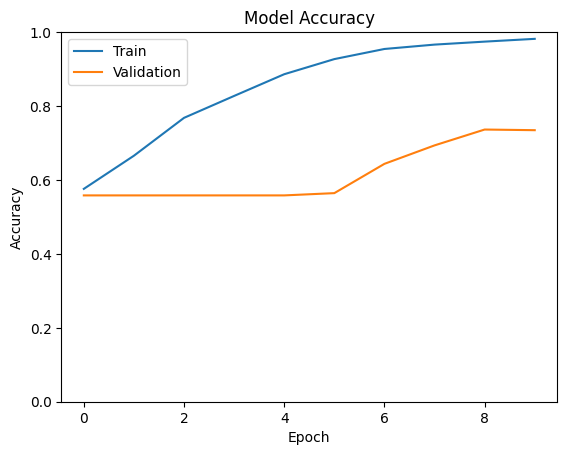

In [105]:
plt.plot(model3_hist.history['accuracy'])
plt.plot(model3_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.ylim(0, 1)
plt.show()

It appears that our validation accuracy sat stagnant for the first few epochs then started to increase. This can be a sign that we ran into a vanishing gradient issue.

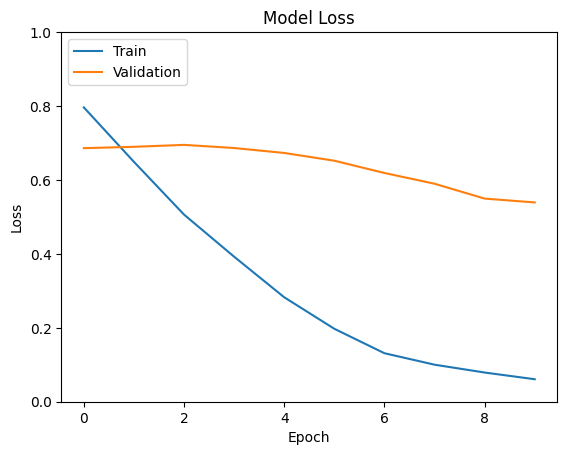

In [106]:
plt.plot(model3_hist.history['loss'])
plt.plot(model3_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.ylim(0, 1)
plt.show()

Our validation loss is remaining somewhat level. It looks like our solutions might not have impacted the overfitting of the model. We will discuss why in the conclusion. First let's check the accuracy of the predictions from this model.

In [94]:
df_sample_sub3 = pd.read_csv(io.BytesIO(uploaded['sample_submission.csv']))

In [96]:
pred3 = model3.predict(X_test_pad)
for i in range(len(pred3)):
    if pred[i] > 0.5:
        df_sample_sub3['target'][i] = 1
    else:
        df_sample_sub3['target'][i] = 0

102/102 [==============================] - 0s 5ms/step


After uploading our predictions to Kaggle, the second model scored 76%. Almost exactly the same as the previous model. Let’s discuss why in the conclusion.

# Conclusion

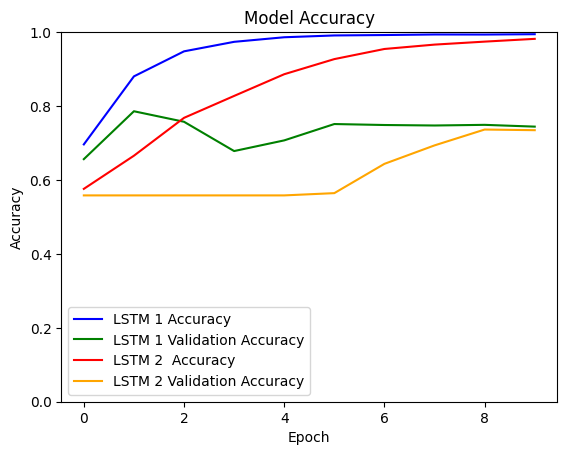

In [107]:
plt.plot(model2_hist.history['accuracy'], label = 'LSTM 1 Accuracy', color = 'b')
plt.plot(model2_hist.history['val_accuracy'],label = 'LSTM 1 Validation Accuracy', color = 'g')
plt.plot(model3_hist.history['accuracy'],label = 'LSTM 2  Accuracy', color = 'r')
plt.plot(model3_hist.history['val_accuracy'],label = 'LSTM 2 Validation Accuracy', color = 'orange')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.ylim(0, 1)
plt.show()

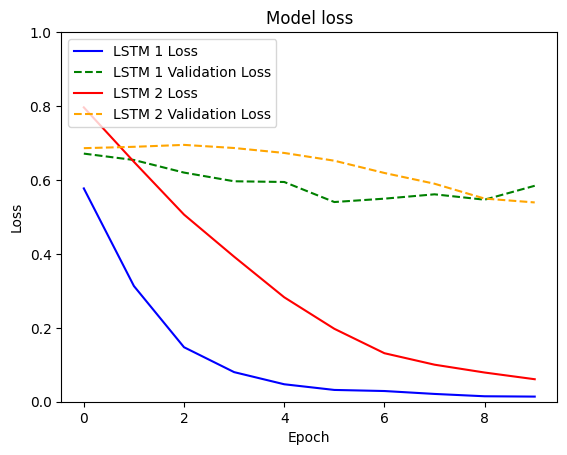

In [103]:
plt.plot(model2_hist.history['loss'], label = 'LSTM 1 Loss', color = 'b')
plt.plot(model2_hist.history['val_loss'], label = 'LSTM 1 Validation Loss',linestyle='dashed', color = 'g')
plt.plot(model3_hist.history['loss'],label = 'LSTM 2 Loss', color = 'r')
plt.plot(model3_hist.history['val_loss'],label = 'LSTM 2 Validation Loss',linestyle='dashed', color = 'orange')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.ylim(0, 1)
plt.show()

First, let’s take a look at our results. Both models scored about 76% accurate on the test data. However, we can see that the models vary. We can see that the first model was able to train the data faster. This may have indicated that there was overfitting, so we added dropout layers and reduced the number of hidden units. This caused the model to learn slower but still did not address the issue of the loss not decreasing.

Our goal was to predict whether a tweet was referring to a natural disaster or not. From a set of 7600 tweets, we trained NLP RNN models to predict this.
We first used a simple RNN model and saw how the simple RNN models can fall victim to the vanishing descent problem. So, we switched to the LSTM RNN model that is designed to handle longer sequence data. Our LSTM model was able to predict 76% of the 3300 test tweets as being an authentic disaster tweet or not.


In the future, to improve our model we may want to adjust the batch size in the models, update the momentum of the optimizer, and varying weight initializations. Another factor may be the number of tweets in our training set. More tweets would prevent our data from learning the data too quickly and overfitting.

# Refernces




*   https://www.kaggle.com/competitions/nlp-getting-started/overview
*   https://www.tensorflow.org/text/tutorials/text_classification_rnn
*   https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
*   https://www.analyticsvidhya.com/blog/2021/06/lstm-for-text-classification/#h-lstm-python-for-text-classification
*   https://towardsdatascience.com/learn-how-recurrent-neural-networks-work-84e975feaaf7
*   https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4



In [97]:
#from google.colab import files

In [ ]:
#df_sample_sub.target.value_counts()

0    2173
1    1090
Name: target, dtype: int64

In [ ]:
#df_sample_sub.to_csv('output.csv', encoding = 'utf-8-sig')
#files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
#df_sample_sub3.to_csv('output3.csv', encoding = 'utf-8-sig')
#files.download('output3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>